# Obtain spatial and angle resolved grain maps of PARADIM-1 in the focus beam

In [3]:
%run -i ../tomography/utils.py

In [4]:
%run -i startup3.py

## Extract the peak positions

### Load and reformat the data

`db_raw` is the databroker database.

In [7]:
sel_row = df_uid.loc[5]
sel_row

uid       cf821cac-cdb1-49e7-8bf9-c10cb677f0a3
sample                               PARADIM-1
task            redo coarse rocking curve at 0
beam                                     focus
Name: 5, dtype: object

In [8]:
run = db_raw[sel_row['uid']]
data = reformat_data(run.xarray_dask())
image_data = data["dexela_image"]

In [9]:
data

<xarray.Dataset>
Dimensions:               (dim_0: 1, dim_1: 3888, dim_2: 3072, frame: 1100)
Coordinates:
  * frame                 (frame) int64 0 1 2 3 4 5 ... 1095 1096 1097 1098 1099
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    dexela_stats1_total   (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dexela_image          (frame, dim_0, dim_1, dim_2) float64 dask.array<chunksize=(1, 1, 3888, 3072), meta=np.ndarray>
    mXBase                (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mXBase_user_setpoint  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mPhi                  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mPhi_user_setpoint    (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase                (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase_user_setpoint  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [10]:
del sel_row

### Filter the images

We filter the images according to the `dexela_stats1_total` which is the sum of intensity on the image. The powder diffraction image has much higher intensity than the single crystal diffraction image and the air scattering image.

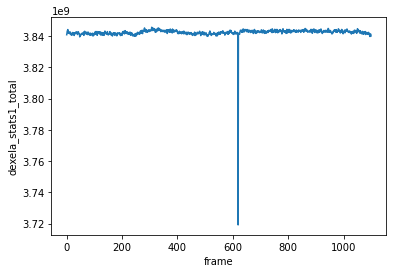

In [11]:
image_sum_data = data['dexela_stats1_total'].compute()
image_sum_data.plot();

In [15]:
sel_image_sum_data = image_sum_data
sel_image_sum_data = sel_image_sum_data[sel_image_sum_data / 1e9 > 3.76]

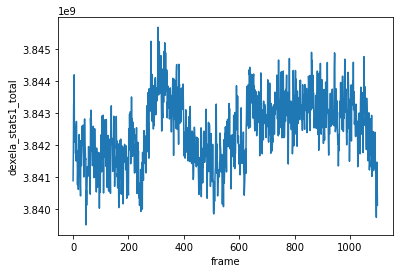

In [16]:
sel_image_sum_data.plot()

### Run again with the filtered images

Get the maximum and minimum of pixel values for the images of the non-powder part.

In [18]:
sel_image_data = image_data[sel_image_sum_data.frame.values]
shadows = min_and_max_along_time(sel_image_data)
shadows = shadows.astype(np.int16)

In [19]:
db_cdf.insert(shadows.to_dataset(name="shadow"), dict(**run.start, tag="max and min frame"))

'60c9469061ea7f7e74faa66a'

In [20]:
del shadows

### Visualize the averaged light and dark frame

In [21]:
shadows = db_cdf.get_data("60c9469061ea7f7e74faa66a")["shadow"]

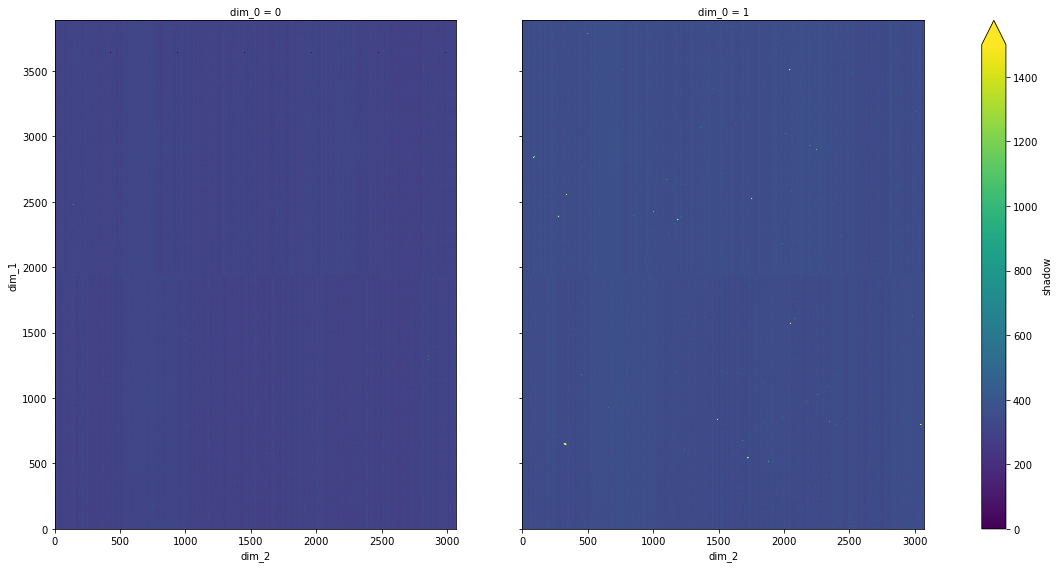

In [24]:
facet = shadows.plot(col="dim_0", size=8, vmax=1500)
set_real_aspect(facet.axes)

The result shows all the shinning points that ever appeared in any of the frames. Some look like Bragg peaks while the other look like a part of powder diffraction rings.

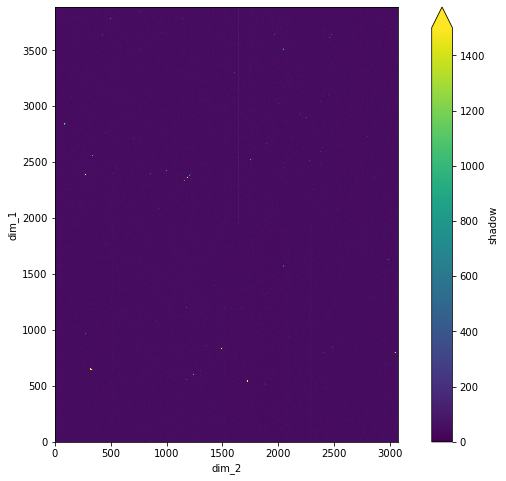

In [25]:
subtracted_shadow = shadows[1] - shadows[0]
facet = subtracted_shadow.plot(size=8, vmax=1500)
set_real_aspect(facet.axes)

## Locate the peak positions and track it

### Locate the spots

Use `trackpy.locate` to find the spots on the image.

In [26]:
df = tp.locate(subtracted_shadow.values, diameter=51, percentile=67., engine="numba", threshold=600, minmass=2000)
df

,y,x,mass,size,ecc,signal,raw_mass,ep
0,543.879076,1722.537120,300505.139347,3.649396,0.057760,6007.966962,449080.0,0.009164
1,648.839392,326.657978,513330.070307,6.878784,0.679347,7955.946532,728934.0,0.005127
2,798.768345,3044.465809,186829.333756,3.256177,0.099305,6200.421659,329316.0,0.013820
3,836.398306,1490.397533,138712.202443,3.154500,0.100497,3534.098213,270506.0,0.018414
4,1157.012678,1600.020861,13332.001368,1.049844,0.254312,2685.914642,108426.0,0.219680
5,1572.625433,2048.263586,153371.411346,3.057803,0.078554,4222.863224,280410.0,0.017438
6,1954.850863,1623.993868,15222.743912,1.110652,0.166096,2881.826608,114291.0,0.157418
7,2364.932262,1187.791434,287826.946148,3.174697,0.040851,7126.201734,438541.0,0.009444
8,2389.449935,275.274958,526724.686676,3.389571,0.029584,12587.151755,697839.0,0.005391
9,2525.740462,1753.964179,104912.010304,2.423767,0.098506,4754.514520,227967.0,0.024243


In [31]:
db_csv.insert(df, dict(**run.start, tag="located features on the shadow image"))

'60ca131961ea7f7e74faa66b'

In [32]:
del df

### Select the ones to track

We select the 20 largest peaks to track.

In [33]:
df = db_csv.get_data("60ca131961ea7f7e74faa66b")

In [34]:
peaks = df.sort_values("mass", ascending=False).iloc[:20]
windows = create_windows_from_width(peaks, 25)

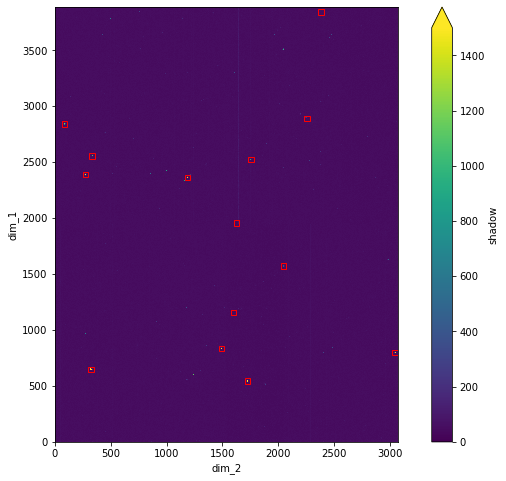

In [35]:
facet = subtracted_shadow.plot(size=8, vmax=1500)
set_real_aspect(facet.axes)
draw_windows(windows, facet.axes)
plt.show()

In [36]:
del facet

### Run the tracking

In [37]:
grains = create_grain_maps(image_data, windows, run.start)

In [38]:
db_cdf.insert(grains, dict(**run.start, tag="grain maps"))

'60ca1ca161ea7f7e74faa66c'

In [39]:
del grains

### Visualize the grain maps

This is the final result of 20 grain maps. They are visualized in a log scale color map.

In [44]:
grains = db_cdf.get_data("60ca1ca161ea7f7e74faa66c")
grains = grains.set_index({"grain": ["x", "y"]})
grains

<xarray.Dataset>
Dimensions:  (dim_0: 11, dim_1: 4, dim_2: 25, grain: 14)
Coordinates:
  * dim_2    (dim_2) float64 0.24 0.23 0.22 0.21 0.2 ... 0.04 0.03 0.02 0.01 0.0
  * grain    (grain) MultiIndex
  - x        (grain) int64 275 327 1723 1188 89 3044 ... 336 2258 1624 1600 2380
  - y        (grain) int64 2389 649 544 2365 2843 ... 2558 2891 1955 1157 3845
  * dim_0    (dim_0) float64 20.0 18.0 16.0 14.0 12.0 10.0 8.0 6.0 4.0 2.0 0.0
  * dim_1    (dim_1) float64 3.0 2.0 1.0 0.0
Data variables:
    dx       (grain) int32 25 25 25 25 25 25 25 25 25 25 25 25 25 25
    dy       (grain) int32 25 25 25 25 25 25 25 25 25 25 25 25 25 25
    maps     (dim_0, dim_1, dim_2, grain) float64 324.0 312.2 ... 314.9 319.3

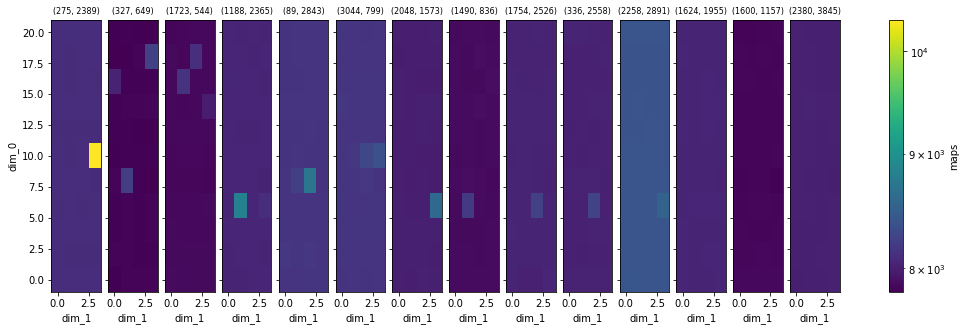

In [63]:
facet = plot_grain_maps(grains.sum(dim="dim_2"), norm=mpl.colors.LogNorm())
facet.set_titles(template="{value}", size=8)
del facet

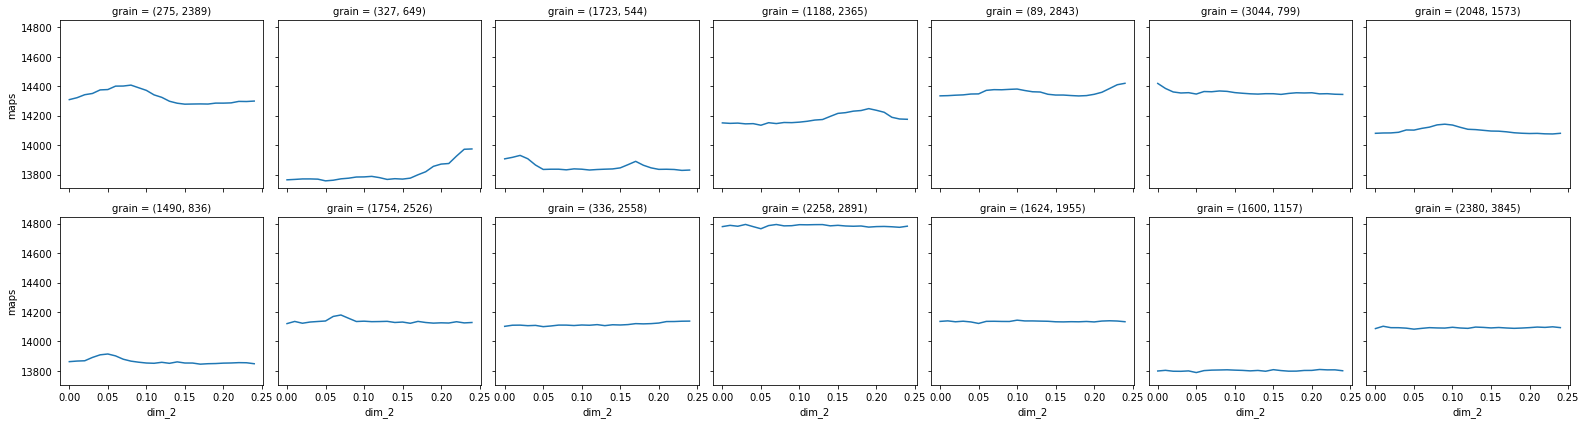

In [60]:
facet = grains["maps"].sum(dim=["dim_0", "dim_1"]).plot(col="grain", col_wrap=7)
del facet

### The mean of the grain maps

It shows the total distribution of all 20 grains.

In [62]:
mean_map = grains["maps"].mean(dim="grain")

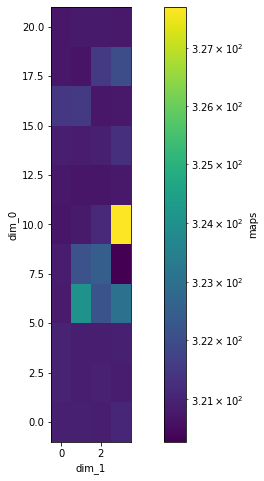

In [67]:
facet = mean_map.mean(dim="dim_2").plot.pcolormesh(size=8, norm=mpl.colors.LogNorm())
set_real_aspect(facet.axes)
del facet

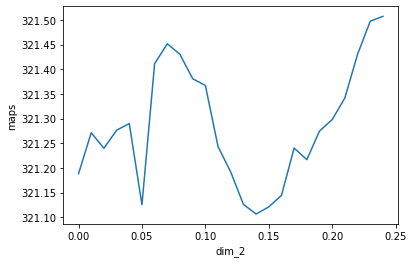

In [66]:
facet = mean_map.mean(dim=["dim_0", "dim_1"]).plot()
del facet